In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline, interp1d
import seaborn as sns
from scipy.special import factorial
import emcee
import corner
from multiprocess import Pool
from numba import njit, vectorize
# from numba_stats import norm
import math
from iminuit import cost, Minuit 
from numba_stats import norm
from tqdm import tqdm

sns.set_context('talk')
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = 661.657
Emin = 640.
Emax = 672.

path = '/Users/sean/COSI/calibration_data/2016/Cs137/'
plot_dir = '/Users/sean/COSI/ChargeTrapping/figures/CCE_fitting/'
dat_all = 'COSI_GCU-040516_091215-204526_Cs137_allmodules.alldata-003.dat'

True


# Use Cs-137 data from 2016 calibrations (Run 90)


## Read in the dat file

In [2]:
df_dat = make_df_from_dat(path+dat_all)

In [3]:
# This is the pixel code alex used in depth calibration
df_dat["pixel_code"] = 10000*df_dat["det"]+100*df_dat["strip_n"]+df_dat["strip_p"]

## Choose a detector and plot the counts as a function of depth

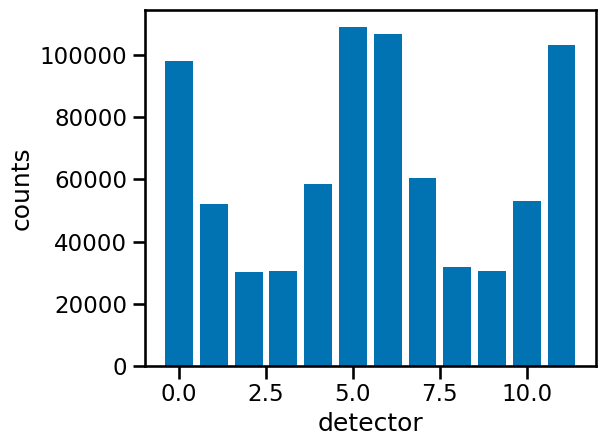

In [4]:
det_counts = [len(df_dat.loc[(df_dat["det"]==i)]) for i in range(12)]
plt.figure()
plt.bar(range(12), det_counts);
# plt.yscale('log')
plt.xlabel("detector")
plt.ylabel("counts")
plt.tight_layout()
# plt.savefig(plot_dir + 'counts_per_det.pdf')

[-5.321   -3.83392 -2.7877  -1.29404 -0.24782 -0.22808  1.259  ]
0.18588499999999997
0.1867075
0.185885


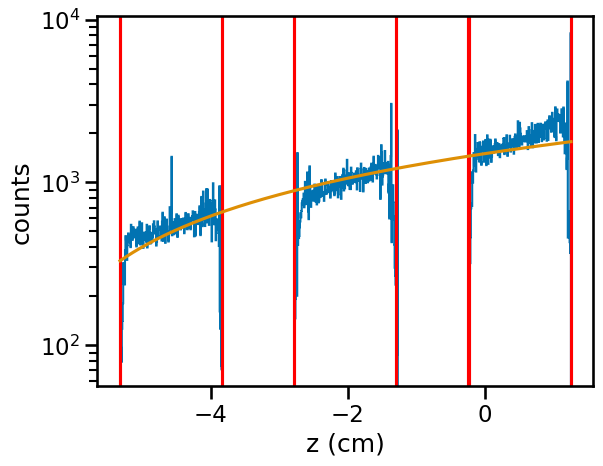

In [5]:
plt.figure()
hist, bins, _ = plt.hist(df_dat["z"], bins=1000, histtype = "step");
plt.yscale('log')
plt.xlabel("z (cm)")
plt.ylabel("counts");

det_edges = np.sort(np.concatenate([[bins[0]], bins[np.argsort((hist[:-1]-hist[1:])/(220*bins[:-2] + 1500))][1:6], [bins[-1]]]))
print(det_edges)
for e in det_edges:
    plt.axvline(e, color='red')
    
plt.plot(bins, 220*bins + 1500)

# plt.figure()
# plt.plot(bins[:-1], hist.astype(bool))

det_edges = [[-5.321, -3.83392], [-2.7877, -1.29404], [-0.22808, 1.259]]
for e in det_edges:
    print((e[1]-e[0])/8)

In [6]:
z_min = det_edges[0][0]       # cm
z_max = det_edges[-1][-1]
temp_list = []
num_z=15
for e in det_edges:
    temp_list.append(np.linspace(e[0],e[1], num_z+1))

z_bins = np.concatenate(temp_list)
z_bins_labels = np.arange(0,len(z_bins)-1)
print(z_bins)
df_dat["z_binned"] = pd.cut(df_dat["z"],bins=z_bins,labels=z_bins_labels)


[-5.321      -5.22186133 -5.12272267 -5.023584   -4.92444533 -4.82530667
 -4.726168   -4.62702933 -4.52789067 -4.428752   -4.32961333 -4.23047467
 -4.131336   -4.03219733 -3.93305867 -3.83392    -2.7877     -2.68812267
 -2.58854533 -2.488968   -2.38939067 -2.28981333 -2.190236   -2.09065867
 -1.99108133 -1.891504   -1.79192667 -1.69234933 -1.592772   -1.49319467
 -1.39361733 -1.29404    -0.22808    -0.12894133 -0.02980267  0.069336
  0.16847467  0.26761333  0.366752    0.46589067  0.56502933  0.664168
  0.76330667  0.86244533  0.961584    1.06072267  1.15986133  1.259     ]


# Plot the simulated dCCE

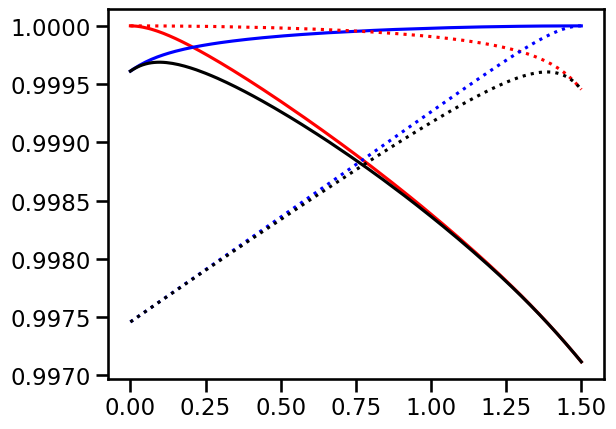

In [7]:
# columns: depth, ACsignal_electron_trapping, ACsignal_hole_trapping, DCsignal_electron_trapping, DCsignal_hole_trapping
# (ACsignal is the electron signal, DCsignal is the hole signal)
# With these curves, then you should in theory be able to fit your curves with the combination:
# electron signal CCE: (1-x*ACsignal_electron_trapping)*(1-y*ACsignal_hole_trapping)+AC_offset(?)
# hole signal CCE: (1-x*DCsignal_electron_trapping)*(1-y*DCsignal_hole_trapping)+DC_offset(?)

det=4
sim_dat = '/Users/sean/COSI/ChargeTrapping/simulation_data/det'+str(det)+'_dCCE_1000cm_15strip.csv'
sim_dCCE = np.loadtxt(sim_dat, delimiter=',').T
plt.plot(sim_dCCE[0], 1-sim_dCCE[1], color='red')
plt.plot(sim_dCCE[0], 1-sim_dCCE[2], color='blue')
plt.plot(sim_dCCE[0], (1-sim_dCCE[1])*(1-sim_dCCE[2]), color='black')
plt.plot(sim_dCCE[0], 1-sim_dCCE[3], color='red', ls='dotted')
plt.plot(sim_dCCE[0], 1-sim_dCCE[4], color='blue', ls='dotted')
plt.plot(sim_dCCE[0], (1-sim_dCCE[3])*(1-sim_dCCE[4]), color='black', ls='dotted')

esig_CCE = (1-sim_dCCE[1])*(1-sim_dCCE[2])
hsig_CCE = (1-sim_dCCE[3])*(1-sim_dCCE[4])

def e_depth_plot(z, ae, b, c):
    CCE = ae*(1.-b*sim_dCCE[1])*(1.-c*sim_dCCE[2])
    return UnivariateSpline(sim_dCCE[0], CCE)(z)

def h_depth_plot(z, ah, b, c):
    CCE = ah*(1.-b*sim_dCCE[3])*(1.-c*sim_dCCE[4])
    return UnivariateSpline(sim_dCCE[0], CCE)(z)

# Perform correction using spline

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[1.44366    1.34408267 1.24450533 1.144928   1.04535067 0.94577333
 0.846196   0.74661867 0.64704133 0.547464   0.44788667 0.34830933
 0.248732   0.14915467 0.04957733]


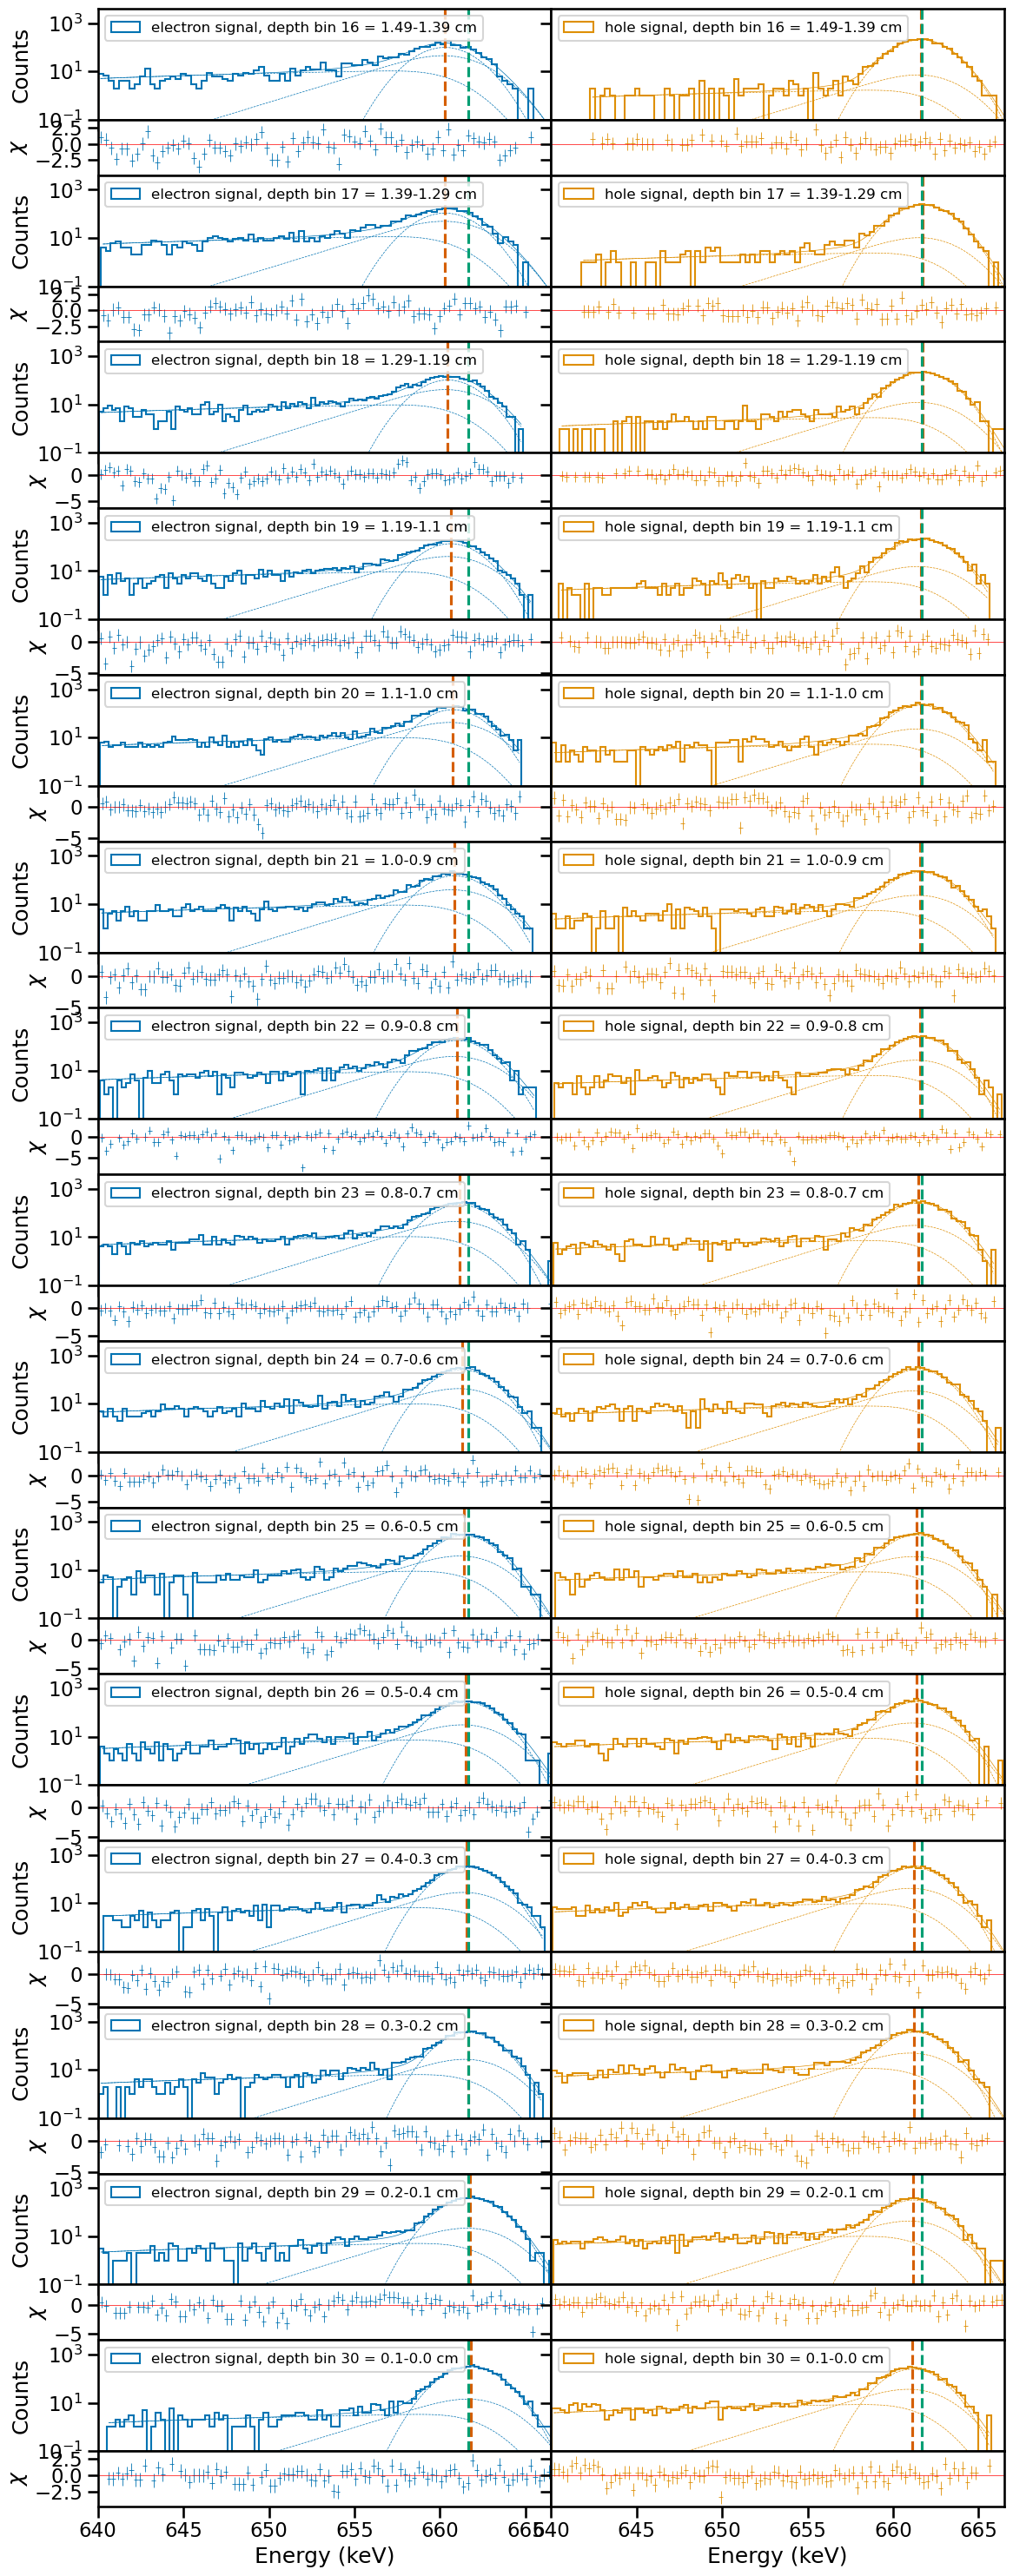

In [8]:
pnflipped = [True, True, True, False, False, False, True, True, True, False, False, False]
det_layers = [2,1,0,0,1,2,2,1,0,0,1,2]
# dets = [0,1,2,3,4,5,6,7,8,9,10,11]
# 11 has high-E excess, messing up fits. 5,6, 10 have low-E bump. 0 and 1 have wiggles near the peak.
# 9 is really broad on the hole signal
# Best-looking fits: 2, 4, 8

df_dat_det = df_dat[df_dat["det"]==det]
z_binned_freq_values = df_dat_det["z_binned"].value_counts().index.to_list()

z_list = []
centroid_list = []
centroid_err_list = []

z_freq_depthsort = np.sort(z_binned_freq_values[:num_z])
print(z_freq_depthsort)

if pnflipped[det]:
    top = det_edges[det_layers[det]][0]
else:
    top = det_edges[det_layers[det]][1]

fig, axes = plt.subplots(figsize = (12, 30), nrows=num_z*2, ncols=2, sharex=True, sharey='row', \
                        gridspec_kw={'hspace':0, 'wspace':0, 'height_ratios':np.array([(2,1) for i in range(num_z)]).flatten()})
for i in range(num_z):

    z = z_freq_depthsort[i]
    z_list.append(z)

    if pnflipped[det]:
        label = "depth bin {} = {}-{} cm".format(z,round(z_bins[z]-top,2),round(z_bins[z+1]-top,2))
    else:
        label = "depth bin {} = {}-{} cm".format(z,round(top - z_bins[z],2),round(top - z_bins[z+1],2))

    # fit both sides
    temp_x0 = []
    temp_x0_err = []
    for j, side in enumerate(['p', 'n']):
        if side=='p':
            carrier='electron'
        else:
            carrier='hole'

        ax = axes[i*2][j]
        resid_ax = axes[(i*2)+1][j]            
        color = 'C' + str(j)

        energies = df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values
        hist,binedges,_ = ax.hist((df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values),
                                   histtype="step",color=color,bins=100,label=carrier + " signal, " + label)

        bin_centers = np.array((binedges[:-1] + binedges[1:]) / 2)

        c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

        m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=0.8, gamma=global_gamma, CoverB=global_CoverB, linearm=global_linearm, sigma_ratio=global_sigma_ratio, \
                   Emin=640., Emax=672.)
        m.limits["x0"] = (650., 672.)
        m.limits["BoverA", "sigma_gauss"] = (0, None)
        m.fixed["gamma", "CoverB", "linearm", "sigma_ratio", "Emin", "Emax"] = True
        m.migrad()
        m.hesse()

        BoverA, x0, sigma_gauss = m.values[:3]
        A = np.sum(hist)*(bin_centers[1]-bin_centers[0])/\
            quad(gauss_plus_tail, 640., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
        # print(m.values)
        # print(m.errors['x0'])
        temp_x0.append(m.values['x0'])
        temp_x0_err.append(m.errors['x0'])
        # print(c(*m.values))
        # print(np.sum(np.log(gauss_plus_tail_pdf(df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, *m.values))))
        B = A*BoverA
        C = B*global_CoverB

        ax.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= color, lw=0.5)
        resid_ax.errorbar(bin_centers[hist>0], \
                           (hist[hist>0] - gauss_plus_tail(bin_centers[hist>0],A, BoverA, x0, sigma_gauss))/np.sqrt(hist[hist>0]), \
                           xerr=(bin_centers[1]-bin_centers[0])/2, yerr=1., ls='', lw=0.6, color=color)
        ax.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, global_linearm)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color= color, ls='--', lw=0.5)
        ax.axvline(x0, ls='--', color='C3')
        ax.axvline(Cs_line, ls='--', color='C2')
        if j==0:
            ax.set_ylabel("Counts")
        ax.set_yscale('log')
        ax.set_ylim((0.1, 4000))
        ax.legend(loc=2, fontsize=12)
        resid_ax.axhline(0, color='red', lw=0.5)        

    axes[(i*2)+1][0].set_ylabel(r'$\chi$')
    centroid_list.append(temp_x0)
    centroid_err_list.append(temp_x0_err)

axes[-1][0].set_xlim(Emin,666.5)
axes[-1][1].set_xlim(Emin,666.5)
axes[-1][0].set_xlabel("Energy (keV)")
axes[-1][1].set_xlabel("Energy (keV)")
plt.tight_layout()    

centroid_list = np.array(centroid_list)
centroid_err_list = np.array(centroid_err_list)

if pnflipped[det]:
    depth = z_bins[z_list]-top+1.5/(num_z*2.)
else:
    depth = top - z_bins[z_list]-1.5/(num_z*2.)
print(depth)

In [9]:
epopt, epcov = curve_fit(e_depth_plot, depth, centroid_list.T[0], p0=[662., 1.0, 0.5], sigma=centroid_err_list.T[0])
hpopt, hpcov = curve_fit(h_depth_plot, depth, centroid_list.T[1], p0=[662., 1.0, 0.5], sigma=centroid_err_list.T[1])

c = cost.LeastSquares(depth, centroid_list.T[0], centroid_err_list.T[0], e_depth_plot) + cost.LeastSquares(depth, centroid_list.T[1], centroid_err_list.T[1], h_depth_plot)

m = Minuit(c, ae=662., ah=662., b=1.0, c=0.5)
m.limits["b", "c"] = (0, None)
m.migrad()
m.hesse()
# m.minos()

print(m)

plt.figure()

plt.errorbar(depth,centroid_list.T[0],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[0],fmt=" ",label="electron signal")
plt.errorbar(depth,centroid_list.T[1],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[1],fmt=" ",label="hole signal")

plt.plot(depth, e_depth_plot(depth, *m.values['ae', 'b', 'c']), color='C0', zorder=0, lw=0.9)
plt.plot(depth, h_depth_plot(depth, *m.values['ah', 'b', 'c']), color='C1', zorder=0, lw=0.9)

plt.axhline(Cs_line, ls='--', color='C2', zorder=0)
plt.legend()
plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
# plt.ylim((660., 662.))
plt.tight_layout()
plt.savefig(plot_dir + 'e_hole_trapping_det'+str(det)+'_energy_fit_15strip.pdf')
plt.close()

plt.figure()

plt.errorbar(depth,centroid_list.T[0]/m.values['ae'],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[0]/m.values['ae'],fmt=" ",label="electron signal")
plt.errorbar(depth,centroid_list.T[1]/m.values['ah'],xerr = 1.5/(num_z*2.), yerr=centroid_err_list.T[1]/m.values['ah'],fmt=" ",label="hole signal")

plt.plot(depth, e_depth_plot(depth, *m.values['ae', 'b', 'c'])/m.values['ae'], color='C0', zorder=0, lw=0.9)
plt.plot(depth, h_depth_plot(depth, *m.values['ah', 'b', 'c'])/m.values['ah'], color='C1', zorder=0, lw=0.9)

plt.legend()
plt.xlabel("Detector Depth (cm)"); plt.ylabel("CCE")
plt.ylim(top=1.0)
plt.tight_layout()
plt.savefig(plot_dir + 'e_hole_trapping_det'+str(det)+'_CCE_fit_15strip.pdf')
plt.close()

depth_plot_fit = m


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.04 (χ²/ndof = 1.3)      │              Nfcn = 122              │
│ EDM = 1.39e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [73]:
### Correct the spectra on each side, separately.
z_corr_factor = {"p": Cs_line/np.array(centroid_list.T[0]), "n": Cs_line/np.array(centroid_list.T[1])}
# xs = np.linspace(650, 672, int(1e6))
for j, side in enumerate(z_corr_factor):
    print(side + '-side')
    color = 'C' + str(j)

    uncorr_energies = []
    corr_energies = []

    for i in range(num_z):
        
        z = z_freq_depthsort[i]
        z_cm = z_bins[z]
        
        ev_depth = top - df_dat_det[df_dat_det["z_binned"]==z]['z'].values-1.5/(num_z*2.)
        # print(np.min(ev_depth), np.max(ev_depth))
        
        uncorr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values)
        
        if side=='p':
            corr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values * Cs_line/e_depth_plot(ev_depth, *depth_plot_fit.values['ae', 'b', 'c']))
        else:
            corr_energies.append(df_dat_det[df_dat_det["z_binned"]==z]["energy_"+side].values * Cs_line/h_depth_plot(ev_depth, *depth_plot_fit.values['ah', 'b', 'c']))

    uncorr_energies = np.concatenate(uncorr_energies)
    corr_energies = np.concatenate(corr_energies)

    uncorr_energies = uncorr_energies[uncorr_energies > 645.]
    corr_energies = corr_energies[corr_energies > 645.]

    plt.figure(figsize=(9,6))
    hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
    hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

    # Plot uncorrected data
    bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
    c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=0.8, gamma=global_gamma, CoverB=global_CoverB, linearm=global_linearm, sigma_ratio=global_sigma_ratio, \
               Emin=645., Emax=672.)
    m.limits["x0"] = (650., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "linearm", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 645., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Uncorrected FWHM: ", round(2.355*m.values['sigma_gauss'], 5), ' +/- ', round(2.355*m.errors['sigma_gauss'], 5))
    print('1 - Uncorrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
      round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))

    temp_sigma_uncorr = m.values['sigma_gauss']
    temp_sigma_err_uncorr = m.errors['sigma_gauss']

    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C3', lw=0.5)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, global_linearm)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C3', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C3')


    # Next plot corrected data
    bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
    c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

    m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=0.8, gamma=global_gamma, CoverB=global_CoverB, linearm=global_linearm, sigma_ratio=global_sigma_ratio, \
               Emin=645., Emax=672.)
    m.limits["x0"] = (650., 672.)
    m.limits["BoverA", "sigma_gauss"] = (0, None)
    m.fixed["gamma", "CoverB", "linearm", "sigma_ratio", "Emin", "Emax"] = True
    m.migrad()
    m.hesse()

    BoverA, x0, sigma_gauss = m.values[:3]
    A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
        quad(gauss_plus_tail, 645., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
    # print(m.values)
    # print(m.errors['x0'])
    B = A*BoverA
    C = B*global_CoverB

    print("Corrected FWHM: ", round(2.355*m.values['sigma_gauss'], 5), ' +/- ', round(2.355*m.errors['sigma_gauss'], 5))
    print('1 - Corrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
      round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))

    temp_sigma_corr = m.values['sigma_gauss']
    temp_sigma_err_corr = m.errors['sigma_gauss']

    print('Delta FWHM:', round(2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)), 5), ' +/- ', \
      round(2.355*np.sqrt(np.square(temp_sigma_corr*temp_sigma_err_corr)+\
                          np.square(temp_sigma_uncorr*temp_sigma_err_uncorr))/np.sqrt(np.square(temp_sigma_uncorr)-np.square(temp_sigma_corr)), 5))

    plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C2', lw=0.5)
    plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, global_linearm)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C2', ls='--', lw=0.5)
    plt.axvline(m.values['x0'], ls='--', color='C2')


    if side =='p':
        plt.text(653., np.max(hist_corr)*0.2, 'electron signal', color='C0', fontsize=24)
    else:
        plt.text(653., np.max(hist_corr)*0.2, 'hole signal', color='C1', fontsize=24)


    plt.ylabel("Counts")
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.ylim((40., np.max(hist_corr)*1.5))
    plt.xlim(652.,665.)
    plt.legend(loc=2)
    plt.tight_layout()
    plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_' + side + '_CCE.pdf')
    plt.close()

p-side
Uncorrected FWHM:  2.958  +/-  0.01329
1 - Uncorrected centroid/Cs_line: -3.2307814164235302  +/-  -0.00919
Corrected FWHM:  2.86262  +/-  0.01233
1 - Corrected centroid/Cs_line: -4.175627813906044  +/-  -0.07398
Delta FWHM: 0.74511  +/-  0.07091
n-side
Uncorrected FWHM:  2.83073  +/-  0.01101
1 - Uncorrected centroid/Cs_line: -3.456580922479495  +/-  -0.01229
Corrected FWHM:  2.79878  +/-  0.01094
1 - Corrected centroid/Cs_line: -4.566550511178411  +/-  0.15707
Delta FWHM: 0.42405  +/-  0.10302


In [74]:
### Produce corrected spectra averaging between sides
uncorr_energies = []
corr_energies = []

for i in range(num_z):

    z = z_freq_depthsort[i]
    z_cm = z_bins[z]
    
    ev_depth = top - df_dat_det[df_dat_det["z_binned"]==z]['z'].values-1.5/(num_z*2.)

    uncorr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values, \
                                    df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values], axis=0))
    corr_energies.append(np.mean([df_dat_det[df_dat_det["z_binned"]==z]["energy_p"].values * Cs_line/e_depth_plot(ev_depth, *depth_plot_fit.values['ae', 'b', 'c']), \
                                  df_dat_det[df_dat_det["z_binned"]==z]["energy_n"].values * Cs_line/h_depth_plot(ev_depth, *depth_plot_fit.values['ah', 'b', 'c'])], axis=0))
uncorr_energies = np.concatenate(uncorr_energies)
corr_energies = np.concatenate(corr_energies)


uncorr_energies = uncorr_energies[uncorr_energies > 652.]
corr_energies = corr_energies[corr_energies > 652.]

plt.figure(figsize=(9,6))
hist_uncorr,binedges_uncorr,_ = plt.hist(uncorr_energies, histtype="step",bins=100,label="uncorrected", color='C3')
hist_corr,binedges_corr,_ = plt.hist(corr_energies, histtype="step",bins=100,label="corrected", color='C2')

print('----Combined signal----')
# Plot uncorrected data
bin_centers = np.array((binedges_uncorr[:-1] + binedges_uncorr[1:]) / 2)
c = cost.UnbinnedNLL(uncorr_energies, gauss_plus_tail_pdf)

m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=0.8, gamma=global_gamma, CoverB=global_CoverB, linearm=global_linearm, sigma_ratio=global_sigma_ratio, \
           Emin=652., Emax=672.)
m.limits["x0"] = (640., 672.)
m.limits["BoverA", "sigma_gauss"] = (0, None)
m.fixed["gamma", "CoverB", "linearm", "sigma_ratio", "Emin", "Emax"] = True
m.migrad()
m.hesse()

BoverA, x0, sigma_gauss = m.values[:3]
A = np.sum(hist_uncorr)*(bin_centers[1]-bin_centers[0])/\
    quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
# print(m.values)
# print(m.errors['x0'])
B = A*BoverA
C = B*global_CoverB

print("Uncorrected FWHM: ", round(2.355*m.values['sigma_gauss'], 6), ' +/- ', round(2.355*m.errors['sigma_gauss'], 6))
print('1 - Uncorrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
  round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
temp_sigma_uncorr = m.values['sigma_gauss']
temp_sigma_err_uncorr = m.errors['sigma_gauss']

plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C3', lw=0.5)
plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C3', ls='--', lw=0.5)
plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C3', ls='--', lw=0.5)
plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, global_linearm)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C3', ls='--', lw=0.5)
plt.axvline(m.values['x0'], ls='--', color='C3')

# Next plot corrected data
bin_centers = np.array((binedges_corr[:-1] + binedges_corr[1:]) / 2)
c = cost.UnbinnedNLL(corr_energies, gauss_plus_tail_pdf)

m = Minuit(c, BoverA=0.5, x0=Cs_line, sigma_gauss=0.8, gamma=global_gamma, CoverB=global_CoverB, linearm=global_linearm, sigma_ratio=global_sigma_ratio, \
           Emin=652., Emax=672.)
m.limits["x0"] = (650., 672.)
m.limits["BoverA", "sigma_gauss"] = (0, None)
m.fixed["gamma", "CoverB", "linearm", "sigma_ratio", "Emin", "Emax"] = True
m.migrad()
m.hesse()

BoverA, x0, sigma_gauss = m.values[:3]
A = np.sum(hist_corr)*(bin_centers[1]-bin_centers[0])/\
    quad(gauss_plus_tail, 652., 672., args = (1.0, BoverA, x0, sigma_gauss))[0]
# print(m.values)
# print(m.errors['x0'])
B = A*BoverA
C = B*global_CoverB

print("Corrected FWHM: ", round(2.355*m.values['sigma_gauss'], 6), ' +/- ', round(2.355*m.errors['sigma_gauss'], 6))
print('1 - Corrected centroid/Cs_line:', np.log10(np.abs(1. - m.values['x0']/Cs_line)), ' +/- ', \
  round(m.errors['x0']/(np.log(10)*(m.values['x0'] - Cs_line)), 5))
print(A*np.sqrt(2)*m.values['sigma_gauss'])

temp_sigma_corr = m.values['sigma_gauss']
temp_sigma_err_corr = m.errors['sigma_gauss']

print('Delta FWHM:', round(2.355*np.sqrt(np.square(temp_sigma_uncorr) - np.square(temp_sigma_corr)), 5), ' +/- ', \
      round(2.355*np.sqrt(np.square(temp_sigma_corr*temp_sigma_err_corr)+\
                          np.square(temp_sigma_uncorr*temp_sigma_err_uncorr))/np.sqrt(np.square(temp_sigma_uncorr)-np.square(temp_sigma_corr)), 5))

plt.plot(bin_centers,gauss_plus_tail(bin_centers, A, BoverA, x0, sigma_gauss),color= 'C2', lw=0.5)
plt.plot(bin_centers,A*gaussian(bin_centers, x0, sigma_gauss),color='C2', ls='--', lw=0.5)
plt.plot(bin_centers, B*exp_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, gamma=global_gamma)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C2', ls='--', lw=0.5)
plt.plot(bin_centers, C*linear_tail(bin_centers, x0, sigma_gauss/global_sigma_ratio, global_linearm)*shelf(bin_centers, x0, sigma_gauss/global_sigma_ratio),color='C2', ls='--', lw=0.5)
plt.axvline(m.values['x0'], ls='--', color='C2')
# plt.axvline(Cs_line, ls='--', color = 'cyan')

# plt.text(653., np.max(hist_corr)*0.3, r'$e^-\ \mathrm{and}\ h^+$', color='black', fontsize=24)
plt.ylabel("Counts")
plt.yscale('log')
plt.ylim((40., np.max(hist_corr)*1.5))
plt.xlim(652.,665.)
plt.xlabel('Energy (keV)')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig(plot_dir + 'correction_spectra_det_' + str(det) + '_bothsides_CCE.pdf')
plt.close()


----Combined signal----


/Users/sean/COSI/ChargeTrapping/depth_helpers.py:54: RuntimeWarning: invalid value encountered in divide
  return gauss_plus_tail_depth(x, 1., BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_linearm, global_sigma_ratio)/\
/Users/sean/COSI/ChargeTrapping/depth_helpers.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail_depth, Emin, Emax, args=(1., BoverA, x0, sigma_gauss, global_gamma, global_CoverB, global_linearm, global_sigma_ratio))[0]


Uncorrected FWHM:  2.196927  +/-  0.00022
1 - Uncorrected centroid/Cs_line: -3.26997617470446  +/-  -0.00112
Corrected FWHM:  2.181522  +/-  0.010456
1 - Corrected centroid/Cs_line: -4.2928390577099425  +/-  -0.08498
3741.727856878723
Delta FWHM: 0.25971  +/-  0.08785
